In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

import pickle
import mlflow
import time
import xgbfir

import optuna
import optuna.visualization as vis

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

# Scalers
from sklearn.preprocessing import label_binarize

from imblearn.over_sampling import SMOTE, ADASYN

# Metrics
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve, precision_recall_curve, f1_score

# Model
from xgboost import XGBClassifier, plot_importance

# Model Selection - XGBoost

## 1. Load Data

In [2]:
attributes = pd.read_csv("data/btc_price_data_1_year_attributes.csv")
attributes.set_index('timestamp', inplace=True, drop = True)
attributes

,open,high,low,close,volume,month,day,weekday,hour,hour_sin,...,lag_47,lag_56,RSI,EMA12,EMA26,MACD,Signal_Line,SMA,EMA,future_return
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-11-01 00:56:00,34524.12,34549.26,34541.45,34524.49,31.117144,11,1,2,0,0.000000,...,34619.47,34667.88,47.431310,34542.664324,34556.581568,-13.917244,-12.759288,34553.5310,34550.874620,0.000377
2023-11-01 00:57:00,34524.13,34537.66,34524.52,34524.62,7.349951,11,1,2,0,0.000000,...,34603.20,34642.82,48.755135,34539.888274,34554.214045,-14.325771,-13.072585,34549.4505,34548.374180,-0.005330
2023-11-01 00:58:00,34519.85,34531.41,34527.81,34522.78,5.134526,11,1,2,0,0.000000,...,34602.26,34656.56,48.265451,34537.256232,34551.885597,-14.629365,-13.383941,34545.2715,34545.936639,0.025461
2023-11-01 00:59:00,34521.42,34531.98,34521.42,34531.57,4.310564,11,1,2,0,0.000000,...,34623.10,34629.34,41.702541,34536.381427,34550.380738,-13.999311,-13.507015,34542.0065,34544.568387,0.021053
2023-11-01 01:00:00,34531.46,34547.87,34532.22,34538.84,1.327905,11,1,2,1,0.258819,...,34611.54,34622.27,48.144440,34536.759669,34549.525868,-12.766199,-13.358852,34540.4225,34544.022827,0.011263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 23:55:00,70248.97,70264.97,70248.98,70248.97,1.604753,10,31,3,23,-0.258819,...,70345.60,70383.13,15.731750,70316.514762,70363.992465,-47.477702,-35.505422,70367.7305,70348.638181,-0.014534
2024-10-31 23:56:00,70238.76,70248.97,70248.97,70238.76,1.189134,10,31,3,23,-0.258819,...,70329.38,70461.07,20.028025,70304.552491,70354.715986,-50.163495,-38.437037,70352.5490,70338.173592,-0.007859
2024-10-31 23:57:00,70218.00,70250.00,70238.77,70233.24,4.767082,10,31,3,23,-0.258819,...,70317.72,70470.15,14.761536,70293.581339,70345.717765,-52.136426,-41.176915,70338.1685,70328.179916,-0.036251


In [3]:
target_data = pd.read_csv("data/btc_price_data_1_year_target.csv")
target_data.set_index('timestamp', inplace=True, drop = True)
target = target_data['target']
target

timestamp
2023-11-01 00:56:00    0
2023-11-01 00:57:00    0
2023-11-01 00:58:00    0
2023-11-01 00:59:00    0
2023-11-01 01:00:00    0
                      ..
2024-10-31 23:55:00    0
2024-10-31 23:56:00    0
2024-10-31 23:57:00    0
2024-10-31 23:58:00    0
2024-10-31 23:59:00    0
Name: target, Length: 528575, dtype: int64

## 2. Data Splitting

In [4]:
attributes_train, attributes_test, target_train, target_test = train_test_split(
    attributes, 
    target, 
    test_size=0.2, 
    shuffle = False,
    random_state = 42
)

In [5]:
attributes_train.shape, attributes_test.shape

((422860, 52), (105715, 52))

In [6]:
target_train.shape, target_test.shape

((422860,), (105715,))

## 3. Oversampling- Address Class Imbalance

**SMOTE** (Synthetic Minority Oversampling Technique) and **ADASYN** (Adaptive Synthetic Sampling) are two popular oversampling techniques for addressing class imbalance in datasets. Both generate synthetic samples for the minority class to balance the dataset, but they differ in how they create these samples. Below is a detailed comparison to help you understand their strengths and use cases.

##### **Core Approach**

###### **SMOTE**
- **How it works**: 
  - For each minority class sample, SMOTE selects one or more nearest neighbors.
  - It creates synthetic samples by interpolating between the sample and its neighbors.
  - The interpolation is linear, producing samples along the line segments between the selected points.
- **Focus**: Generates synthetic samples evenly across the minority class.

###### **ADASYN**
- **How it works**: 
  - ADASYN builds on SMOTE by focusing more on the minority class samples that are harder to classify.
  - It identifies minority samples near the decision boundary (using k-nearest neighbors) and generates more synthetic samples in these regions.
  - The number of synthetic samples per instance is proportional to the local difficulty (measured by the density of majority class samples nearby).
- **Focus**: Creates samples adaptively, concentrating on areas where the minority class is harder to learn.

---

##### **Key Differences**

| Feature                     | **SMOTE**                                  | **ADASYN**                                      |
|-----------------------------|---------------------------------------------|------------------------------------------------|
| **Generation Strategy**     | Uniformly interpolates between samples.     | Focuses on generating samples near decision boundaries. |
| **Focus**                   | Balances the dataset evenly.               | Adaptive oversampling based on instance difficulty.      |
| **Synthetic Sample Location** | Can lead to over-generalization.           | More targeted and refined near complex regions. |
| **Computational Complexity**| Relatively lower computational cost.        | Slightly higher due to the adaptive nature.     |
| **Risk of Overfitting**     | Higher risk if the boundary is noisy.       | Reduced overfitting near decision boundaries.   |

---

##### **Strengths**

###### **SMOTE**
- **Advantages**:
  - Simple and effective for moderately imbalanced datasets.
  - Maintains the distribution of the minority class.
- **When to Use**:
  - When the imbalance is not extreme.
  - When you want a more uniform oversampling approach.

###### **ADASYN**
- **Advantages**:
  - Focuses on challenging regions, improving the model's ability to classify difficult cases.
  - Reduces the risk of overgeneralization by targeting specific areas.
- **When to Use**:
  - For highly imbalanced datasets.
  - When the minority class has complex boundaries or is under-represented in critical regions.

---

##### **Limitations**

###### **SMOTE**
- Does not consider the difficulty of classification.
- Can create synthetic samples in regions that are already well-represented, potentially leading to redundancy.
- May cause overfitting in noisy datasets.

###### **ADASYN**
- Slightly more computationally expensive than SMOTE.
- If the data is very noisy, it might generate samples in misleading or non-representative regions.


### 3.1. SMOTE (Synthetic Minority Oversampling Technique)

In [7]:
def create_oversampling_smote(attributes_train, target_train):
    """
    Apply SMOTE(Synthetic Minority Oversampling Technique) to generate synthetic examples for minority classes
    """
    smote = SMOTE(random_state=42)
    attributes_train_smote, target_train_smote = smote.fit_resample(attributes_train, target_train)
    
    print("Original Class Distribution (SMOTE):", np.bincount(target_train))
    print("Balanced Class Distribution (SMOTE):", np.bincount(target_train_smote))

    return attributes_train_smote, target_train_smote

### 3.2. ADASYN (Adaptive Synthetic Sampling)

In [8]:
def create_oversampling_adasyn(attributes_train, target_train):
    """
    Apply ADASYN(Adaptive Synthetic Sampling) to generate synthetic examples for minority classes
    """
    adasyn = ADASYN(random_state=42)
    attributes_train_adasyn, target_train_adasyn = adasyn.fit_resample(attributes_train, target_train)
    
    print("Original Class Distribution (ADASYN):", np.bincount(target_train))
    print("Balanced Class Distribution (ADASYN):", np.bincount(target_train_adasyn))

    return attributes_train_adasyn, target_train_adasyn

### 3.3. Set Oversampling Type

In [9]:
def create_oversampling(attributes_train, target_train, oversampling_type = None):
    """
    Apply 'oversampling_type' to generate synthetic examples for minority classes
    """
    if oversampling_type == 'smote':
        return create_oversampling_smote(attributes_train, target_train)
    elif oversampling_type == 'adasyn':
        return create_oversampling_adasyn(attributes_train, target_train)
    else:
        print(f"Invalid oversampling type: [{oversampling_type}]")
        return attributes_train, target_train

## 5. Evaluate the Model

**ROC-AUC score:**
   - Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes (1 and 2):

**Precision-Recall Curves:**
   - Precision-recall curves are often more informative for imbalanced datasets. They focus on the trade-off between precision and recall for each class.

In [13]:
def plot_classification_report_multiclass(model, attributes_test_data, target_test_data): 
    # Predictions
    target_pred_data = model.predict(attributes_test_data, verbose=-1)

    # Calculate F1-score (weighted)
    f1 = f1_score(target_test_data, target_pred_data, average='macro')

    print(f"\nF1 score (macro) : [{f1}]")
    
    # Classification Report
    print("\nClassification report: ")
    print(classification_report(target_test_data, target_pred_data))

In [10]:
def plot_feature_importance_xgb(model):
    # The number of times a feature appears in a tree
    plot_importance(model, importance_type = "weight")
    
    # The average gain of splits which use the feature
    plot_importance(model, importance_type = "gain")
    
    # The average coverage of splits which use the feature
    plot_importance(model, importance_type = "cover")

In [15]:
def plot_confusion_matrix(model, attributes_test_data, target_test_data):
    # Predictions
    target_pred_data = model.predict(attributes_test_data, verbose=-1)
    
    # Confusion Matrix Computation
    cm = confusion_matrix(target_test_data, target_pred_data)
    #print("Confusion Matrix:\n", cm)
    
    # Confusion Matrix Visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], 
                yticklabels=['Class 0', 'Class 1', 'Class 2'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [16]:
def plot_classification_error(model, eval_metric='mlogloss'):
    # Retrieve evaluation results
    eval_results = model.evals_result_
    
    # Plot classification error
    plt.figure(figsize=(10, 6))
    plt.plot(eval_results['training'][eval_metric], label='Train Error')
    plt.plot(eval_results['valid_1'][eval_metric], label='Validation Error')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Classification Error')
    plt.title(f"Classification Error ({eval_metric}) During Training ")
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def plot_roc_curve_multiclass(model,target_test_data, classes):
    print(f"\nCalculate the ROC-AUC score for each class individually to see how well the model performs for the minority classes")
    
    # Binarize labels for one-vs-rest (multiclass ROC-AUC)
    target_test_binarized = label_binarize(target_test_data, classes = classes)
    target_pred_prob = model.predict_proba(attributes_test) # predicted probabilities

    # ROC-AUC for multiclass
    roc_auc = roc_auc_score(target_test, target_pred_prob, multi_class='ovr') # 'ovr' (one-vs-rest), 'ovo'-(one-vs-one)
    print(f"\nROC-AUC Score: {roc_auc}")
    
    # Compute ROC-AUC for each class
    roc_auc_per_class = roc_auc_score(target_test_binarized, target_pred_prob, average=None)
    print(f"ROC-AUC per class {classes}:", roc_auc_per_class)

    # Compute ROC curve and ROC-AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(target_test_binarized[:, i], target_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Plot the diagonal
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    
    # Configure the plot
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [18]:
def plot_precision_recal_curve_multiclass(model,target_test_data, classes):
    # Binarize labels for one-vs-rest (multiclass precision-recall)
    target_test_binarized = label_binarize(target_test_data, classes = classes)
    target_pred_prob = model.predict_proba(attributes_test) # predicted probabilities
    
    # Plot precision-recall curves for each class
    for i in range(3):  # Assuming 3 classes (0, 1, 2)
        precision, recall, _ = precision_recall_curve(target_test_binarized[:, i], target_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [19]:
def plot_feature_importance(model):
    # Feature importances
    importances = model.feature_importances_
    feature_names = attributes_train.columns
    sorted_indices = importances.argsort()
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
    plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
    plt.title('Feature Importance')
    plt.show()

In [20]:
def evaluate_model(model, attributes_test_data, target_test_data):
    classes = [0, 1, 2]
    
    plot_classification_report_multiclass(model, attributes_test_data, target_test_data)
    plot_feature_importance_xgb(model)
    plot_confusion_matrix(model, attributes_test_data, target_test_data)
    plot_classification_error(model, eval_metric='multi_logloss')
    plot_classification_error(model, eval_metric='merror')
    plot_roc_curve_multiclass(model, target_test_data, classes)
    plot_precision_recal_curve_multiclass(model, target_test_data, classes)

In [21]:
# evaluate_model(lgb_model, attributes_test, target_test)

## 4. Hyperparameter Tuning

We will use **Optuna** for the hyperparameter tuning.

##### Recommended Parameters to Tune:
- `max_depth` (e.g., 3, 5, 7): Controls tree depth. Deeper trees can model complex patterns but risk overfitting.
- `learning_rate` (e.g., 0.01, 0.05, 0.1): Smaller values improve convergence stability.
- `n_estimators` (e.g., 100, 300, 500): More estimators improve performance but increase training time.
- `subsample` (e.g., 0.6, 0.8, 1.0): Helps with overfitting by randomly sampling rows.
- `colsample_bytree` (e.g., 0.6, 0.8, 1.0): Helps with overfitting by randomly sampling features.
- `scale_pos_weight` (e.g., 1, 10, 50): Adjusts for class imbalance. Compute as `total_negative_samples / total_positive_samples`.

In [19]:
initial_xgboost_model_parameters = {
    'objective': 'multi:softmax',                                  # Multiclass classification
    'num_class': 3,                                                # Number of target classes
    'eval_metric': ['mlogloss', 'merror'],                         # Evaluation metric
    'max_depth': 6,                                                # Controls model complexity
    'learning_rate': 0.1,                                          # Step size for weight updates
    'n_estimators': 300,                                           # Number of boosting rounds
    'subsample': 0.8,                                              # Fraction of data used for training
    'colsample_bytree': 0.8,                                       # Fraction of features used
    'reg_alpha': 0.5,                                                # L1 regularization
    'reg_lambda': 0.07,                                              # L2 regularization
    'min_child_weight': 2,
    #'early_stopping_rounds': 10,                                   # Stop if no improvement in 10 rounds
    'verbosity': 3,
    'n_jobs': 10,
    'random_state': 42
}

### 4.1. Optuna

#### 4.1.1. Define the Objective Function

The objective function tests different hyperparameter combinations and evaluates their performance using cross-validation.

In [13]:
def train_model(model_params, attributes_train_data, target_train_data, attributes_test_data, target_test_data, oversampling_type = None, log_evaluation_period = 10):
    print("\nmodel_params:", model_params)
    
    # Apply oversampling to handle class imbalance in training data
    attributes_train_data_oversampling, target_train_data_oversampling = create_oversampling(
            attributes_train_data,
            target_train_data, 
            oversampling_type
    )
    
    # Use both the training data and validation data in the eval_set to monitor both training and validation performance during training
    eval_set = [
        (attributes_train_data_oversampling, target_train_data_oversampling), # Resampled training data
        (attributes_test_data, target_test_data)    # Original validation data
    ]

    # Create XGBClassifier with the params
    xgb_model = XGBClassifier(**model_params)
        
    # Train XGBoost model
    xgb_model.fit(
        attributes_train_data_oversampling,
        target_train_data_oversampling,
        eval_set = eval_set,
        verbose=False)
    
    # Evaluate the model
    # evaluate_model(lgb_model, attributes_test_data, target_test_data)
    
    return xgb_model

In [14]:
def fit_model_with_timeseries_split(model_params, attributes_train_data, target_train_data, attributes_test_data, target_test_data, oversampling_type = None, log_evaluation_period = 10):
    """
    Cross-Validate with TimeSeriesSplit - using TimeSeriesSplit on the training data to ensure 
    the model performs consistently across different time windows.
    """
     # Metrics collection
    scores = {
        #  The F1 score is the harmonic mean of precision and recall. The 'macro' version calculates the F1 score 
        #  for each class independently and then averages them, giving equal weight to all classes, regardless of their size
        'f1_macro_scores' : [],
        # Balanced accuracy is the average of recall obtained on each class. It accounts for class imbalance 
        # by giving equal weight to each class
        'balanced_acc_scores' : [],
        'f1_weighted_scores' : [],
        'kappa_scores' : [],
        'log_loss_scores' : [],
        'roc_auc_scores' : [],
    }

    # Use TimeSeriesSplit for time series cross-validation
    tscv = TimeSeriesSplit(n_splits = n_splits)
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(attributes_train_data)):
        attributes_train_fold, attributes_val_fold = attributes_train_data.iloc[train_idx], attributes_train_data.iloc[val_idx]
        target_train_fold, target_val_fold = target_train_data.iloc[train_idx], target_train_data.iloc[val_idx]

        # Train the LightGB model with the current fold data
        xgb_model_split = train_model(
            model_params = model_params,
            attributes_train_data = attributes_train_fold,
            target_train_data = target_train_fold,
            attributes_test_data = attributes_test_data,
            target_test_data = target_test_data, 
            oversampling_type = oversampling_type,
            log_evaluation_period = log_evaluation_period)

        # Predictions and probabilities
        target_val_pred = xgb_model_split.predict(attributes_val_fold)
        target_val_proba = xgb_model_split.predict_proba(attributes_val_fold)
        
        # Calculate metrics for this fold
        scores['f1_macro_scores'].append(f1_score(target_val_fold, target_val_pred, average='macro'))
        scores['f1_weighted_scores'].append(f1_score(target_val_fold, target_val_pred, average='weighted'))
        scores['balanced_acc_scores'].append(balanced_accuracy_score(target_val_fold, target_val_pred))
        scores['kappa_scores'].append(cohen_kappa_score(target_val_fold, target_val_pred))
        scores['log_loss_scores'].append(log_loss(target_val_fold, target_val_proba))
        scores['roc_auc_scores'].append(roc_auc_score(target_val_fold, target_val_proba, multi_class='ovr'))

        print(f"\nFold {fold+1} Classification Report")
        print(classification_report(target_val_fold, target_val_pred))

    # Aggregate metrics across folds
    avg_scores = {metric: np.mean(values) for metric, values in scores.items()}

    print("\nCross-Validated Metrics:")
    print(f"F1-Score (Macro): {avg_scores['f1_macro_scores']:.4f} ± {np.std(scores['f1_macro_scores']):.4f}")
    print(f"F1-Score (Weighted): {avg_scores['f1_weighted_scores']:.4f} ± {np.std(scores['f1_weighted_scores']):.4f}")
    print(f"Balanced Accuracy: {avg_scores['balanced_acc_scores']:.4f} ± {np.std(scores['balanced_acc_scores']):.4f}")
    print(f"Cohen's Kappa: {avg_scores['kappa_scores']:.4f} ± {np.std(scores['kappa_scores']):.4f}")
    print(f"Log Loss: {avg_scores['log_loss_scores']:.4f} ± {np.std(scores['log_loss_scores']):.4f}")
    print(f"ROC-AUC: {avg_scores['roc_auc_scores']:.4f} ± {np.std(scores['roc_auc_scores']):.4f}")

    return avg_scores

In [15]:
def objective(trial, model_type, oversampling_type = None, n_splits = 5, log_evaluation_period = 10):
    print(f"\nStart trial:[{trial.number}] for model:[{model_type}] with time series cross validation, oversampling:[{oversampling_type}] and n_splits:[{n_splits}]")

    # Define the hyperparameters to tune
    params = {
        'objective': 'multi:softmax',                                                # Multiclass classification
        'num_class': 3,                                                              # Number of target classes
        'eval_metric': ['mlogloss', 'merror'],                                       # Evaluation metric
        'max_depth': trial.suggest_int('max_depth', 3, 10),                          # Tree depth - controls model complexity
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log = True),  # Step size for weight updates
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),                 # Number of boosting rounds
        # 'n_estimators': trial.suggest_int('n_estimators', 100, 500),               # Number of boosting rounds
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),                     # Row sampling - fraction of data used for training
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),       # Feature sampling - fraction of features used
        # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),        # Class imbalance - for  a multiclass classification  this parameter can't be applied.
        'reg_alpha': trial.suggest_float("reg_alpha", 0, 10),                        # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 25, log = True),      # L2 regularization --> good values typically fall in [0,10]
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),
        'early_stopping_rounds': 10,                                                  # Stop if no improvement in 10 rounds
        'n_jobs' : 10,
        'random_state': 42
    }

    
    # Train the model with the 'params'
    avg_scores = fit_model_with_timeseries_split(params, attributes_train, target_train, attributes_test, target_test, oversampling_type, log_evaluation_period)

    # Log all scores to Optuna
    trial.set_user_attr("scores", avg_scores)
    
    # Return the mean F1-macro across all folds
    return avg_scores['f1_macro_scores']


In [16]:
# def objective(trial, oversampling_type = None, n_splits = 5):
#     print(f"Start trial:[{trial.number}] with time series cross validation, oversampling:[{oversampling_type}] and n_splits:[{n_splits}]")

#     # Define the hyperparameters to tune
#     params = {
#         'objective': 'multi:softmax',                                                # Multiclass classification
#         'num_class': 3,                                                              # Number of target classes
#         'eval_metric': ['mlogloss', 'merror'],                                       # Evaluation metric
#         'max_depth': trial.suggest_int('max_depth', 3, 10),                          # Tree depth - controls model complexity
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log = True),  # Step size for weight updates
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),                 # Number of boosting rounds
#         # 'n_estimators': trial.suggest_int('n_estimators', 100, 500),               # Number of boosting rounds
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),                     # Row sampling - fraction of data used for training
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),       # Feature sampling - fraction of features used
#         # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),        # Class imbalance - for  a multiclass classification  this parameter can't be applied.
#         'reg_alpha': trial.suggest_float("reg_alpha", 0, 10),                        # L1 regularization
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 25, log = True),      # L2 regularization --> good values typically fall in [0,10]
#         'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),
#         'random_state': 42,
#         'early_stopping_rounds': 10,                                                  # Stop if no improvement in 10 rounds
#         'n_jobs' : 9
#     }

#     # Use TimeSeriesSplit for time series cross-validation
#     tscv = TimeSeriesSplit(n_splits = n_splits)
    
#     f1_scores = []  # Store F1-scores for each fold

#     for fold, (train_idx, val_idx) in enumerate(tscv.split(attributes)):
#         attributes_train_fold, attributes_val_fold = attributes.iloc[train_idx], attributes.iloc[val_idx]
#         target_train_fold, target_val_fold = target.iloc[train_idx], target.iloc[val_idx]

#         # Apply oversampling to handle class imbalance in training data
#         attributes_train_fold, target_train_fold = create_oversampling(
#             attributes_train_fold,
#             target_train_fold, 
#             oversampling_type
#         )

#         # Create XGBClassifier with the params
#         model = XGBClassifier(**params)
        
#         # Train XGBoost model
#         model.fit(attributes_train_fold,
#                   target_train_fold,
#                   eval_set=[(attributes_val_fold, target_val_fold)],
#                   verbose=False)

#         # Predictions and probabilities
#         target_val_pred = rf_model_split.predict(attributes_val_fold)
#         target_val_proba = rf_model_split.predict_proba(attributes_val_fold)

#         # Calculate metrics for this fold
#         f1_macro_scores.append(f1_score(target_val_fold, target_val_pred, average='macro'))
#         f1_weighted_scores.append(f1_score(target_val_fold, target_val_pred, average='weighted'))
#         balanced_acc_scores.append(balanced_accuracy_score(target_val_fold, target_val_pred))
#         kappa_scores.append(cohen_kappa_score(target_val_fold, target_val_pred))
#         log_loss_scores.append(log_loss(target_val_fold, target_val_proba))
#         roc_auc_scores.append(roc_auc_score(target_val_fold, target_val_proba, multi_class='ovr'))

#         print(f"Fold {fold+1} Classification Report")
#         print(classification_report(target_val_fold, target_val_pred))
    
#     # Return the mean F1-macro across all folds
#     return np.mean(f1_macro_scores)

#### 4.1.2. Run the Optuna Study in MLFlow

In [27]:
# Set model type
model_type = 'XGBoost'

# Set oversampling type
oversampling_type = 'adasyn'

n_trials = 2 # default : 50
n_splits = 2 # default : 5
posfix = '_test_1'
mlflow_run_name = f"BTC_{model_type}_Optuna_{oversampling_type}_Trials_{n_trials}{posfix}"

print("Oversampling Type:", oversampling_type)
print("n_trials:", n_trials)
print("n_splits:", n_splits)
print("mlflow_run_name:", mlflow_run_name)

Oversampling Type: adasyn
n_trials: 2
n_splits: 2
mlflow_run_name: BTC_XGBoost_Optuna_adasyn_Trials_2_test_1


In [28]:
# model_type = 'XGBClassifier'
# n_trials = 3 # default : 50
# n_splits = 3 # default : 5
# posfix = ''
# mlflow_run_name = f"BTC_{model_type}_Optuna_{oversampling_type}-{n_trials}-Trials{posfix}"

In [29]:
# Create a MLFlow experiment
experiment_name = f"BTC_{model_type}_Optuna"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None: 
    mlflow.create_experiment(experiment_name)

In [30]:
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/valch/OneDrive/Desktop/03.Machine%20Learning-September-2024/Exam/02.Exam-Project/01.Repo/Algorithmic-Trading-Bot/Notebook/mlruns/683265721719547756', creation_time=1732646850521, experiment_id='683265721719547756', last_update_time=1732646850521, lifecycle_stage='active', name='BTC_XGBoost_Optuna', tags={}>

[I 2024-11-28 18:59:06,401] A new study created in memory with name: no-name-818d2359-119d-4d6c-be75-146ad733eaf3


Start trial:[0] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.31      0.13      0.19       209
           2       0.18      0.09      0.12       247

    accuracy                           0.99     88095
   macro avg       0.50      0.41      0.44     88095
weighted avg       0.99      0.99      0.99     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]
Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87564
           1       0.24      0.10      0.15       248
           2       0.26      0.27      0.26       283

    accuracy        

[I 2024-11-28 19:05:06,663] Trial 0 finished with value: 0.9924774481577364 and parameters: {'max_depth': 6, 'learning_rate': 0.1641968297517487, 'n_estimators': 219, 'subsample': 0.8133074672486945, 'colsample_bytree': 0.7707009708822918, 'reg_alpha': 6.200639807578034, 'reg_lambda': 0.05247770856460159, 'min_child_weight': 3}. Best is trial 0 with value: 0.9924774481577364.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.42      0.08      0.13       225
           2       0.29      0.10      0.15       221

    accuracy                           0.99     88095
   macro avg       0.57      0.39      0.43     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[1] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.23      0.13      0.17       209
           2       0.18      0.12      0.14       247

    accuracy                           0.99     88095
   macro avg       0.47      0.41      0.43     88095
weighted avg       0.99      0.9

[I 2024-11-28 19:09:39,759] Trial 1 finished with value: 0.9861199442976074 and parameters: {'max_depth': 10, 'learning_rate': 0.09534873978664442, 'n_estimators': 257, 'subsample': 0.883895369576001, 'colsample_bytree': 0.9895140453012482, 'reg_alpha': 3.5124066825866027, 'reg_lambda': 0.0029107808160035898, 'min_child_weight': 6}. Best is trial 0 with value: 0.9924774481577364.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.50      0.07      0.12       225
           2       0.34      0.10      0.15       221

    accuracy                           0.99     88095
   macro avg       0.61      0.39      0.42     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[2] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     87639
           1       0.05      0.82      0.10       209
           2       0.06      0.78      0.12       247

    accuracy                           0.93     88095
   macro avg       0.37      0.84      0.39     88095
weighted avg       0.99      0.9

[I 2024-11-28 19:11:14,633] Trial 2 finished with value: 0.9611811123489848 and parameters: {'max_depth': 8, 'learning_rate': 0.01849939882488806, 'n_estimators': 151, 'subsample': 0.7229195825832451, 'colsample_bytree': 0.6852636487129894, 'reg_alpha': 0.4356363539590391, 'reg_lambda': 9.933598845195846, 'min_child_weight': 3}. Best is trial 0 with value: 0.9924774481577364.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87649
           1       0.07      0.86      0.13       225
           2       0.06      0.85      0.11       221

    accuracy                           0.94     88095
   macro avg       0.38      0.88      0.40     88095
weighted avg       0.99      0.94      0.96     88095

Start trial:[3] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     87639
           1       0.05      0.84      0.09       209
           2       0.06      0.79      0.12       247

    accuracy                           0.93     88095
   macro avg       0.37      0.85      0.39     88095
weighted avg       0.99      0.9

[I 2024-11-28 19:13:27,261] Trial 3 finished with value: 0.9621591428315275 and parameters: {'max_depth': 9, 'learning_rate': 0.020975848550171122, 'n_estimators': 129, 'subsample': 0.8240671620724187, 'colsample_bytree': 0.9226006228273212, 'reg_alpha': 6.681659398090823, 'reg_lambda': 0.35496998902078414, 'min_child_weight': 9}. Best is trial 0 with value: 0.9924774481577364.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     87649
           1       0.10      0.80      0.18       225
           2       0.08      0.76      0.15       221

    accuracy                           0.96     88095
   macro avg       0.39      0.84      0.43     88095
weighted avg       0.99      0.96      0.97     88095

Start trial:[4] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87639
           1       0.05      0.86      0.09       209
           2       0.06      0.87      0.11       247

    accuracy                           0.92     88095
   macro avg       0.37      0.88      0.38     88095
weighted avg       0.99      0.9

[I 2024-11-28 19:15:04,346] Trial 4 finished with value: 0.9551379735886417 and parameters: {'max_depth': 8, 'learning_rate': 0.021296218911689587, 'n_estimators': 170, 'subsample': 0.6281084394399016, 'colsample_bytree': 0.9542104123733458, 'reg_alpha': 3.6933477138021886, 'reg_lambda': 0.018847787252505275, 'min_child_weight': 9}. Best is trial 0 with value: 0.9924774481577364.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87649
           1       0.11      0.77      0.19       225
           2       0.10      0.76      0.17       221

    accuracy                           0.97     88095
   macro avg       0.40      0.83      0.45     88095
weighted avg       0.99      0.97      0.98     88095

Start trial:[5] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     87639
           1       0.12      0.56      0.20       209
           2       0.13      0.47      0.21       247

    accuracy                           0.98     88095
   macro avg       0.42      0.67      0.47     88095
weighted avg       0.99      0.9

[I 2024-11-28 19:17:36,935] Trial 5 finished with value: 0.9825049504946509 and parameters: {'max_depth': 3, 'learning_rate': 0.14493125900065837, 'n_estimators': 147, 'subsample': 0.6608656642679553, 'colsample_bytree': 0.9121429919721207, 'reg_alpha': 8.863915202922595, 'reg_lambda': 12.349141706879001, 'min_child_weight': 6}. Best is trial 0 with value: 0.9924774481577364.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     87649
           1       0.16      0.62      0.25       225
           2       0.13      0.63      0.22       221

    accuracy                           0.98     88095
   macro avg       0.43      0.75      0.49     88095
weighted avg       0.99      0.98      0.99     88095

Start trial:[6] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.27      0.14      0.18       209
           2       0.20      0.12      0.15       247

    accuracy                           0.99     88095
   macro avg       0.49      0.42      0.44     88095
weighted avg       0.99      0.9

[I 2024-11-28 19:25:31,845] Trial 6 finished with value: 0.9924917428114034 and parameters: {'max_depth': 5, 'learning_rate': 0.08317863161170598, 'n_estimators': 494, 'subsample': 0.819334038009101, 'colsample_bytree': 0.8411033835011062, 'reg_alpha': 4.685127068390118, 'reg_lambda': 2.493990454763215, 'min_child_weight': 6}. Best is trial 6 with value: 0.9924917428114034.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.38      0.09      0.15       225
           2       0.23      0.13      0.16       221

    accuracy                           0.99     88095
   macro avg       0.53      0.41      0.44     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[7] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.30      0.11      0.16       209
           2       0.22      0.10      0.13       247

    accuracy                           0.99     88095
   macro avg       0.50      0.40      0.43     88095
weighted avg       0.99      0.9

[I 2024-11-28 19:30:12,046] Trial 7 finished with value: 0.9925056757496001 and parameters: {'max_depth': 7, 'learning_rate': 0.11115568683727389, 'n_estimators': 204, 'subsample': 0.6528088866605161, 'colsample_bytree': 0.8245607031027425, 'reg_alpha': 1.761932519416154, 'reg_lambda': 0.001018415653294599, 'min_child_weight': 10}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.42      0.09      0.15       225
           2       0.29      0.11      0.16       221

    accuracy                           0.99     88095
   macro avg       0.57      0.40      0.43     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[8] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.31      0.15      0.20       209
           2       0.21      0.15      0.18       247

    accuracy                           0.99     88095
   macro avg       0.50      0.43      0.46     88095
weighted avg       0.99      0.9

[I 2024-11-28 19:34:11,615] Trial 8 finished with value: 0.9918261323049904 and parameters: {'max_depth': 5, 'learning_rate': 0.1090470445545408, 'n_estimators': 195, 'subsample': 0.9535848671769446, 'colsample_bytree': 0.863979386141176, 'reg_alpha': 0.2657409596274585, 'reg_lambda': 1.1725969960384834, 'min_child_weight': 10}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.25      0.11      0.15       225
           2       0.23      0.24      0.24       221

    accuracy                           0.99     88095
   macro avg       0.49      0.45      0.46     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[9] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     87639
           1       0.08      0.81      0.14       209
           2       0.08      0.81      0.15       247

    accuracy                           0.95     88095
   macro avg       0.39      0.86      0.42     88095
weighted avg       0.99      0.9

[I 2024-11-28 19:38:05,988] Trial 9 finished with value: 0.9676399126916431 and parameters: {'max_depth': 4, 'learning_rate': 0.03576215705264983, 'n_estimators': 207, 'subsample': 0.7241132258185459, 'colsample_bytree': 0.6267252440051762, 'reg_alpha': 9.741945226499514, 'reg_lambda': 0.0062322224054635455, 'min_child_weight': 1}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     87649
           1       0.08      0.84      0.15       225
           2       0.08      0.88      0.15       221

    accuracy                           0.95     88095
   macro avg       0.39      0.89      0.43     88095
weighted avg       0.99      0.95      0.97     88095

Start trial:[10] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87639
           1       0.05      0.86      0.09       209
           2       0.04      0.63      0.08       247

    accuracy                           0.92     88095
   macro avg       0.36      0.80      0.38     88095
weighted avg       0.99      0.

[I 2024-11-28 19:39:50,772] Trial 10 finished with value: 0.9637875209377782 and parameters: {'max_depth': 7, 'learning_rate': 0.04706944678337104, 'n_estimators': 359, 'subsample': 0.6059278700663032, 'colsample_bytree': 0.730524639778652, 'reg_alpha': 2.274400224800025, 'reg_lambda': 0.0010464530013337765, 'min_child_weight': 8}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87649
           1       0.06      0.91      0.12       225
           2       0.06      0.84      0.12       221

    accuracy                           0.93     88095
   macro avg       0.38      0.89      0.40     88095
weighted avg       0.99      0.93      0.96     88095

Start trial:[11] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.26      0.11      0.16       209
           2       0.21      0.10      0.13       247

    accuracy                           0.99     88095
   macro avg       0.49      0.40      0.43     88095
weighted avg       0.99      0.

[I 2024-11-28 19:45:59,299] Trial 11 finished with value: 0.9807483585511964 and parameters: {'max_depth': 6, 'learning_rate': 0.06255244916047617, 'n_estimators': 499, 'subsample': 0.736488085407632, 'colsample_bytree': 0.8357264455602043, 'reg_alpha': 2.5745539062920986, 'reg_lambda': 1.4122561224101358, 'min_child_weight': 7}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.34      0.11      0.16       225
           2       0.24      0.14      0.18       221

    accuracy                           0.99     88095
   macro avg       0.53      0.42      0.45     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[12] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.30      0.14      0.19       209
           2       0.23      0.13      0.17       247

    accuracy                           0.99     88095
   macro avg       0.51      0.42      0.45     88095
weighted avg       0.99      0.

[I 2024-11-28 19:52:39,363] Trial 12 finished with value: 0.992331193590944 and parameters: {'max_depth': 5, 'learning_rate': 0.07810580410319767, 'n_estimators': 365, 'subsample': 0.8724711276628871, 'colsample_bytree': 0.8106622921175466, 'reg_alpha': 4.9341665940067285, 'reg_lambda': 0.12427440232234124, 'min_child_weight': 4}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.34      0.12      0.17       225
           2       0.24      0.17      0.20       221

    accuracy                           0.99     88095
   macro avg       0.53      0.43      0.46     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[13] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87639
           1       0.05      0.87      0.09       209
           2       0.05      0.84      0.10       247

    accuracy                           0.92     88095
   macro avg       0.37      0.88      0.38     88095
weighted avg       0.99      0.

[I 2024-11-28 19:53:17,575] Trial 13 finished with value: 0.9483532401627125 and parameters: {'max_depth': 7, 'learning_rate': 0.010214219495505945, 'n_estimators': 491, 'subsample': 0.9875867748335592, 'colsample_bytree': 0.8663385673020577, 'reg_alpha': 1.7486491643554996, 'reg_lambda': 1.9668314807520708, 'min_child_weight': 10}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87649
           1       0.05      0.92      0.10       225
           2       0.05      0.84      0.10       221

    accuracy                           0.92     88095
   macro avg       0.37      0.90      0.39     88095
weighted avg       0.99      0.92      0.95     88095

Start trial:[14] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.27      0.17      0.21       209
           2       0.22      0.10      0.13       247

    accuracy                           0.99     88095
   macro avg       0.49      0.42      0.45     88095
weighted avg       0.99      0.

[I 2024-11-28 19:56:56,652] Trial 14 finished with value: 0.9924495393934599 and parameters: {'max_depth': 5, 'learning_rate': 0.1941757036492412, 'n_estimators': 315, 'subsample': 0.7833857336881763, 'colsample_bytree': 0.7754693937345718, 'reg_alpha': 5.519595561191527, 'reg_lambda': 0.3120391184542028, 'min_child_weight': 5}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.34      0.11      0.16       225
           2       0.25      0.14      0.18       221

    accuracy                           0.99     88095
   macro avg       0.53      0.42      0.45     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[15] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     87639
           1       0.13      0.44      0.20       209
           2       0.15      0.40      0.22       247

    accuracy                           0.98     88095
   macro avg       0.43      0.61      0.47     88095
weighted avg       0.99      0.

[I 2024-11-28 20:04:00,895] Trial 15 finished with value: 0.9850788594497255 and parameters: {'max_depth': 3, 'learning_rate': 0.05778619796735581, 'n_estimators': 436, 'subsample': 0.6911167184280048, 'colsample_bytree': 0.7176122190008216, 'reg_alpha': 7.706711764533533, 'reg_lambda': 3.5615803384912548, 'min_child_weight': 1}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     87649
           1       0.18      0.51      0.27       225
           2       0.15      0.55      0.23       221

    accuracy                           0.98     88095
   macro avg       0.44      0.68      0.50     88095
weighted avg       0.99      0.98      0.99     88095

Start trial:[16] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.29      0.12      0.17       209
           2       0.20      0.11      0.14       247

    accuracy                           0.99     88095
   macro avg       0.49      0.41      0.44     88095
weighted avg       0.99      0.

[I 2024-11-28 20:07:52,990] Trial 16 finished with value: 0.9924514174211305 and parameters: {'max_depth': 8, 'learning_rate': 0.12576617545597946, 'n_estimators': 270, 'subsample': 0.8655312781069645, 'colsample_bytree': 0.8766503828860529, 'reg_alpha': 3.434902127192945, 'reg_lambda': 0.032282650903276484, 'min_child_weight': 8}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.54      0.09      0.15       225
           2       0.27      0.09      0.13       221

    accuracy                           0.99     88095
   macro avg       0.60      0.39      0.43     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[17] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.28      0.21      0.24       209
           2       0.23      0.15      0.18       247

    accuracy                           0.99     88095
   macro avg       0.50      0.45      0.47     88095
weighted avg       0.99      0.

[I 2024-11-28 20:14:58,234] Trial 17 finished with value: 0.992038492846738 and parameters: {'max_depth': 4, 'learning_rate': 0.08027359827759481, 'n_estimators': 428, 'subsample': 0.7553520377833285, 'colsample_bytree': 0.8066752441383548, 'reg_alpha': 4.678216774072225, 'reg_lambda': 0.009371528119003656, 'min_child_weight': 7}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.38      0.13      0.20       225
           2       0.22      0.18      0.20       221

    accuracy                           0.99     88095
   macro avg       0.53      0.44      0.46     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[18] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.05      0.88      0.09       209
           2       0.05      0.92      0.10       247

    accuracy                           0.91     88095
   macro avg       0.37      0.90      0.38     88095
weighted avg       0.99      0.

[I 2024-11-28 20:15:35,061] Trial 18 finished with value: 0.9469327633270103 and parameters: {'max_depth': 6, 'learning_rate': 0.03290838289654446, 'n_estimators': 329, 'subsample': 0.6699382153400449, 'colsample_bytree': 0.75253907264546, 'reg_alpha': 1.3335044958929152, 'reg_lambda': 0.0010142938514696158, 'min_child_weight': 5}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87649
           1       0.06      0.92      0.10       225
           2       0.05      0.90      0.10       221

    accuracy                           0.92     88095
   macro avg       0.37      0.91      0.39     88095
weighted avg       0.99      0.92      0.95     88095

Start trial:[19] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.25      0.16      0.19       209
           2       0.18      0.14      0.16       247

    accuracy                           0.99     88095
   macro avg       0.48      0.43      0.45     88095
weighted avg       0.99      0.

[I 2024-11-28 20:20:12,864] Trial 19 finished with value: 0.9923873691704459 and parameters: {'max_depth': 7, 'learning_rate': 0.10152123144551625, 'n_estimators': 253, 'subsample': 0.9354605990757647, 'colsample_bytree': 0.6617978324570946, 'reg_alpha': 7.385201228128153, 'reg_lambda': 0.11149585715095703, 'min_child_weight': 3}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.40      0.08      0.13       225
           2       0.28      0.10      0.15       221

    accuracy                           0.99     88095
   macro avg       0.56      0.39      0.42     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[20] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     87639
           1       0.07      0.79      0.13       209
           2       0.08      0.82      0.15       247

    accuracy                           0.95     88095
   macro avg       0.38      0.85      0.42     88095
weighted avg       0.99      0.

[I 2024-11-28 20:21:21,771] Trial 20 finished with value: 0.9540307281808105 and parameters: {'max_depth': 4, 'learning_rate': 0.06784583474810721, 'n_estimators': 105, 'subsample': 0.7824002949886495, 'colsample_bytree': 0.9081598188887434, 'reg_alpha': 4.048097914272513, 'reg_lambda': 4.704853192334046, 'min_child_weight': 8}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87649
           1       0.04      0.95      0.08       225
           2       0.04      0.96      0.08       221

    accuracy                           0.89     88095
   macro avg       0.36      0.93      0.37     88095
weighted avg       0.99      0.89      0.94     88095

Start trial:[21] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.29      0.14      0.19       209
           2       0.24      0.11      0.15       247

    accuracy                           0.99     88095
   macro avg       0.51      0.42      0.45     88095
weighted avg       0.99      0.

[I 2024-11-28 20:25:05,191] Trial 21 finished with value: 0.9925045183689696 and parameters: {'max_depth': 6, 'learning_rate': 0.18003809361478898, 'n_estimators': 222, 'subsample': 0.8432185383112192, 'colsample_bytree': 0.7791938324688534, 'reg_alpha': 5.977772630466633, 'reg_lambda': 0.048065060580380244, 'min_child_weight': 3}. Best is trial 7 with value: 0.9925056757496001.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.37      0.08      0.13       225
           2       0.26      0.10      0.15       221

    accuracy                           0.99     88095
   macro avg       0.54      0.39      0.42     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[22] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.29      0.16      0.21       209
           2       0.17      0.09      0.11       247

    accuracy                           0.99     88095
   macro avg       0.49      0.41      0.44     88095
weighted avg       0.99      0.

[I 2024-11-28 20:28:42,183] Trial 22 finished with value: 0.9925482290388308 and parameters: {'max_depth': 6, 'learning_rate': 0.19954819878198565, 'n_estimators': 235, 'subsample': 0.8412850522929206, 'colsample_bytree': 0.8299855535773895, 'reg_alpha': 5.800027435923127, 'reg_lambda': 0.5542228066330899, 'min_child_weight': 2}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.48      0.10      0.16       225
           2       0.32      0.12      0.17       221

    accuracy                           0.99     88095
   macro avg       0.60      0.40      0.44     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[23] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.34      0.16      0.22       209
           2       0.19      0.09      0.13       247

    accuracy                           0.99     88095
   macro avg       0.51      0.42      0.45     88095
weighted avg       0.99      0.

[I 2024-11-28 20:32:25,825] Trial 23 finished with value: 0.992452926293061 and parameters: {'max_depth': 6, 'learning_rate': 0.19843131018836707, 'n_estimators': 231, 'subsample': 0.8566112195989014, 'colsample_bytree': 0.7960638271758371, 'reg_alpha': 6.3552565684102404, 'reg_lambda': 0.5141421860684018, 'min_child_weight': 2}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.46      0.08      0.14       225
           2       0.34      0.11      0.16       221

    accuracy                           0.99     88095
   macro avg       0.60      0.40      0.44     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[24] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.25      0.15      0.19       209
           2       0.19      0.13      0.15       247

    accuracy                           0.99     88095
   macro avg       0.48      0.42      0.44     88095
weighted avg       0.99      0.

[I 2024-11-28 20:36:39,877] Trial 24 finished with value: 0.9924279101231306 and parameters: {'max_depth': 7, 'learning_rate': 0.13863419948257757, 'n_estimators': 288, 'subsample': 0.9075827500133481, 'colsample_bytree': 0.827516443749972, 'reg_alpha': 7.918065052704401, 'reg_lambda': 0.003376658625102143, 'min_child_weight': 2}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.45      0.10      0.17       225
           2       0.33      0.11      0.16       221

    accuracy                           0.99     88095
   macro avg       0.59      0.40      0.44     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[25] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.28      0.15      0.20       209
           2       0.19      0.10      0.13       247

    accuracy                           0.99     88095
   macro avg       0.49      0.42      0.44     88095
weighted avg       0.99      0.

[I 2024-11-28 20:39:53,205] Trial 25 finished with value: 0.9923046187884875 and parameters: {'max_depth': 8, 'learning_rate': 0.16479500125117846, 'n_estimators': 187, 'subsample': 0.8383200218069389, 'colsample_bytree': 0.7356829066930716, 'reg_alpha': 5.858159252957908, 'reg_lambda': 0.07086525055612147, 'min_child_weight': 4}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.35      0.04      0.07       225
           2       0.29      0.09      0.14       221

    accuracy                           0.99     88095
   macro avg       0.54      0.38      0.40     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[26] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.25      0.14      0.18       209
           2       0.17      0.11      0.13       247

    accuracy                           0.99     88095
   macro avg       0.47      0.42      0.44     88095
weighted avg       0.99      0.

[I 2024-11-28 20:43:26,016] Trial 26 finished with value: 0.9921734181797127 and parameters: {'max_depth': 9, 'learning_rate': 0.11234059696960007, 'n_estimators': 230, 'subsample': 0.9019420389744089, 'colsample_bytree': 0.7798956049825301, 'reg_alpha': 7.022175646590776, 'reg_lambda': 0.6048909049008763, 'min_child_weight': 2}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.43      0.07      0.12       225
           2       0.26      0.09      0.13       221

    accuracy                           0.99     88095
   macro avg       0.56      0.38      0.41     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[27] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.26      0.13      0.17       209
           2       0.21      0.10      0.14       247

    accuracy                           0.99     88095
   macro avg       0.49      0.41      0.44     88095
weighted avg       0.99      0.

[I 2024-11-28 20:46:49,149] Trial 27 finished with value: 0.9924961449134585 and parameters: {'max_depth': 6, 'learning_rate': 0.19652143314068382, 'n_estimators': 298, 'subsample': 0.7744663901366153, 'colsample_bytree': 0.7025932815299771, 'reg_alpha': 5.512220010819712, 'reg_lambda': 0.224610034568819, 'min_child_weight': 4}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.41      0.09      0.15       225
           2       0.30      0.12      0.17       221

    accuracy                           0.99     88095
   macro avg       0.57      0.40      0.44     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[28] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.25      0.19      0.22       209
           2       0.17      0.14      0.15       247

    accuracy                           0.99     88095
   macro avg       0.47      0.44      0.45     88095
weighted avg       0.99      0.

[I 2024-11-28 20:50:33,603] Trial 28 finished with value: 0.9923290036213146 and parameters: {'max_depth': 7, 'learning_rate': 0.15066581429042994, 'n_estimators': 176, 'subsample': 0.8453024497969168, 'colsample_bytree': 0.8902634082741432, 'reg_alpha': 8.62836655210155, 'reg_lambda': 0.022559517260515187, 'min_child_weight': 1}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.47      0.12      0.19       225
           2       0.29      0.11      0.16       221

    accuracy                           0.99     88095
   macro avg       0.59      0.41      0.45     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[29] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.34      0.12      0.18       209
           2       0.27      0.09      0.14       247

    accuracy                           0.99     88095
   macro avg       0.54      0.40      0.44     88095
weighted avg       0.99      0.

[I 2024-11-28 20:54:35,210] Trial 29 finished with value: 0.9925003029592263 and parameters: {'max_depth': 6, 'learning_rate': 0.15171334261579525, 'n_estimators': 230, 'subsample': 0.8112616435590984, 'colsample_bytree': 0.7619938393339081, 'reg_alpha': 2.8107277494070555, 'reg_lambda': 0.046380763679930506, 'min_child_weight': 3}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.31      0.07      0.11       225
           2       0.27      0.13      0.18       221

    accuracy                           0.99     88095
   macro avg       0.53      0.40      0.43     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[30] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.25      0.15      0.19       209
           2       0.15      0.10      0.12       247

    accuracy                           0.99     88095
   macro avg       0.47      0.42      0.44     88095
weighted avg       0.99      0.

[I 2024-11-28 20:57:58,315] Trial 30 finished with value: 0.9923137256461209 and parameters: {'max_depth': 9, 'learning_rate': 0.17755308114008203, 'n_estimators': 211, 'subsample': 0.6969254337960812, 'colsample_bytree': 0.8484548446799326, 'reg_alpha': 6.337559061100055, 'reg_lambda': 0.013695344775119273, 'min_child_weight': 2}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.52      0.12      0.20       225
           2       0.28      0.09      0.13       221

    accuracy                           0.99     88095
   macro avg       0.60      0.40      0.44     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[31] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.30      0.11      0.16       209
           2       0.21      0.08      0.11       247

    accuracy                           0.99     88095
   macro avg       0.50      0.40      0.42     88095
weighted avg       0.99      0.

[I 2024-11-28 21:02:13,738] Trial 31 finished with value: 0.992510182253584 and parameters: {'max_depth': 6, 'learning_rate': 0.12506565493579017, 'n_estimators': 241, 'subsample': 0.8074522973550574, 'colsample_bytree': 0.759691850195353, 'reg_alpha': 2.9792598990266113, 'reg_lambda': 0.04762578559120836, 'min_child_weight': 3}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.35      0.08      0.12       225
           2       0.27      0.11      0.16       221

    accuracy                           0.99     88095
   macro avg       0.54      0.40      0.43     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[32] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.29      0.09      0.13       209
           2       0.21      0.06      0.10       247

    accuracy                           0.99     88095
   macro avg       0.50      0.38      0.41     88095
weighted avg       0.99      0.

[I 2024-11-28 21:06:44,455] Trial 32 finished with value: 0.992528575649523 and parameters: {'max_depth': 6, 'learning_rate': 0.12152284806080078, 'n_estimators': 260, 'subsample': 0.8067185191349429, 'colsample_bytree': 0.7914840765580123, 'reg_alpha': 1.2119745101250785, 'reg_lambda': 0.06775168909056097, 'min_child_weight': 3}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.49      0.11      0.18       225
           2       0.36      0.12      0.18       221

    accuracy                           0.99     88095
   macro avg       0.61      0.41      0.45     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[33] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.27      0.19      0.22       209
           2       0.20      0.12      0.15       247

    accuracy                           0.99     88095
   macro avg       0.49      0.44      0.46     88095
weighted avg       0.99      0.

[I 2024-11-28 21:11:12,956] Trial 33 finished with value: 0.9922422387171258 and parameters: {'max_depth': 5, 'learning_rate': 0.12116261476392212, 'n_estimators': 256, 'subsample': 0.758759098857425, 'colsample_bytree': 0.8134662964095323, 'reg_alpha': 1.2507603355229695, 'reg_lambda': 24.289589391097742, 'min_child_weight': 4}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.32      0.10      0.15       225
           2       0.24      0.16      0.19       221

    accuracy                           0.99     88095
   macro avg       0.52      0.42      0.45     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[34] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.33      0.08      0.12       209
           2       0.21      0.06      0.10       247

    accuracy                           0.99     88095
   macro avg       0.51      0.38      0.41     88095
weighted avg       0.99      0.

[I 2024-11-28 21:15:43,937] Trial 34 finished with value: 0.9924786618330442 and parameters: {'max_depth': 7, 'learning_rate': 0.0922065031913092, 'n_estimators': 276, 'subsample': 0.7973466339555386, 'colsample_bytree': 0.7481305191439567, 'reg_alpha': 0.8555585819971352, 'reg_lambda': 0.002592683499336367, 'min_child_weight': 3}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.40      0.06      0.11       225
           2       0.28      0.10      0.15       221

    accuracy                           0.99     88095
   macro avg       0.56      0.39      0.42     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[35] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.36      0.09      0.14       209
           2       0.22      0.07      0.11       247

    accuracy                           0.99     88095
   macro avg       0.53      0.38      0.41     88095
weighted avg       0.99      0.

[I 2024-11-28 21:19:09,648] Trial 35 finished with value: 0.9924388046697551 and parameters: {'max_depth': 8, 'learning_rate': 0.12833705710435855, 'n_estimators': 250, 'subsample': 0.8894157091619468, 'colsample_bytree': 0.6704745274298521, 'reg_alpha': 1.8983438330523659, 'reg_lambda': 0.791630755959543, 'min_child_weight': 5}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.44      0.07      0.12       225
           2       0.32      0.08      0.13       221

    accuracy                           0.99     88095
   macro avg       0.59      0.38      0.42     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[36] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.21      0.20      0.21       209
           2       0.18      0.20      0.19       247

    accuracy                           0.99     88095
   macro avg       0.46      0.47      0.46     88095
weighted avg       0.99      0.

[I 2024-11-28 21:21:53,817] Trial 36 finished with value: 0.9911809317459991 and parameters: {'max_depth': 6, 'learning_rate': 0.0958379110059536, 'n_estimators': 142, 'subsample': 0.8019480090465982, 'colsample_bytree': 0.9556199862756565, 'reg_alpha': 3.155512871864281, 'reg_lambda': 0.1865625849567705, 'min_child_weight': 2}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.23      0.19      0.21       225
           2       0.20      0.24      0.22       221

    accuracy                           0.99     88095
   macro avg       0.47      0.47      0.47     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[37] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     87639
           1       0.13      0.45      0.20       209
           2       0.13      0.45      0.21       247

    accuracy                           0.98     88095
   macro avg       0.42      0.63      0.47     88095
weighted avg       0.99      0.

[I 2024-11-28 21:24:36,069] Trial 37 finished with value: 0.9747079710978042 and parameters: {'max_depth': 5, 'learning_rate': 0.053710347300013485, 'n_estimators': 175, 'subsample': 0.7431946632289492, 'colsample_bytree': 0.7869407735647599, 'reg_alpha': 0.027887552723794506, 'reg_lambda': 0.10144715415647386, 'min_child_weight': 3}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     87649
           1       0.14      0.70      0.23       225
           2       0.14      0.70      0.23       221

    accuracy                           0.98     88095
   macro avg       0.43      0.79      0.49     88095
weighted avg       0.99      0.98      0.98     88095

Start trial:[38] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.22      0.08      0.11       209
           2       0.14      0.06      0.09       247

    accuracy                           0.99     88095
   macro avg       0.45      0.38      0.40     88095
weighted avg       0.99      0.

[I 2024-11-28 21:28:23,499] Trial 38 finished with value: 0.992168780478352 and parameters: {'max_depth': 10, 'learning_rate': 0.071234538302757, 'n_estimators': 154, 'subsample': 0.8246437249538442, 'colsample_bytree': 0.8241270599622338, 'reg_alpha': 1.0044206837402345, 'reg_lambda': 0.006204600836244317, 'min_child_weight': 1}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.40      0.06      0.11       225
           2       0.30      0.07      0.12       221

    accuracy                           0.99     88095
   macro avg       0.56      0.38      0.41     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[39] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.30      0.13      0.18       209
           2       0.18      0.10      0.13       247

    accuracy                           0.99     88095
   macro avg       0.49      0.41      0.44     88095
weighted avg       0.99      0.

[I 2024-11-28 21:31:58,623] Trial 39 finished with value: 0.9925001811846468 and parameters: {'max_depth': 7, 'learning_rate': 0.15545934618109777, 'n_estimators': 201, 'subsample': 0.6441234649461745, 'colsample_bytree': 0.693418480895491, 'reg_alpha': 3.984812855909694, 'reg_lambda': 0.35283736792271625, 'min_child_weight': 7}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.53      0.11      0.18       225
           2       0.33      0.10      0.16       221

    accuracy                           0.99     88095
   macro avg       0.62      0.40      0.44     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[40] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.27      0.11      0.16       209
           2       0.20      0.09      0.13       247

    accuracy                           0.99     88095
   macro avg       0.49      0.40      0.43     88095
weighted avg       0.99      0.

[I 2024-11-28 21:35:42,957] Trial 40 finished with value: 0.9924612055061353 and parameters: {'max_depth': 9, 'learning_rate': 0.1106457613081139, 'n_estimators': 338, 'subsample': 0.703473773487473, 'colsample_bytree': 0.8494129518910236, 'reg_alpha': 2.162606083273136, 'reg_lambda': 0.0019296790894278726, 'min_child_weight': 4}. Best is trial 22 with value: 0.9925482290388308.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.54      0.08      0.15       225
           2       0.32      0.09      0.14       221

    accuracy                           0.99     88095
   macro avg       0.62      0.39      0.43     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[41] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.40      0.08      0.13       209
           2       0.20      0.04      0.07       247

    accuracy                           0.99     88095
   macro avg       0.53      0.38      0.40     88095
weighted avg       0.99      0.

[I 2024-11-28 21:39:38,534] Trial 41 finished with value: 0.9926923128587875 and parameters: {'max_depth': 6, 'learning_rate': 0.17162175913961525, 'n_estimators': 242, 'subsample': 0.8348051679887819, 'colsample_bytree': 0.7924327976006224, 'reg_alpha': 0.524354759427542, 'reg_lambda': 0.06677336125564388, 'min_child_weight': 2}. Best is trial 41 with value: 0.9926923128587875.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.52      0.10      0.17       225
           2       0.41      0.13      0.20       221

    accuracy                           0.99     88095
   macro avg       0.64      0.41      0.46     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[42] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.34      0.10      0.16       209
           2       0.24      0.07      0.11       247

    accuracy                           0.99     88095
   macro avg       0.53      0.39      0.42     88095
weighted avg       0.99      0.

[I 2024-11-28 21:43:51,896] Trial 42 finished with value: 0.9926367962848509 and parameters: {'max_depth': 6, 'learning_rate': 0.1405547619068513, 'n_estimators': 241, 'subsample': 0.8296409426527072, 'colsample_bytree': 0.7944710331218543, 'reg_alpha': 0.5990376743668051, 'reg_lambda': 0.07655178857237162, 'min_child_weight': 2}. Best is trial 41 with value: 0.9926923128587875.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.44      0.09      0.15       225
           2       0.35      0.13      0.19       221

    accuracy                           0.99     88095
   macro avg       0.60      0.41      0.45     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[43] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.35      0.11      0.17       209
           2       0.25      0.07      0.11       247

    accuracy                           0.99     88095
   macro avg       0.53      0.39      0.43     88095
weighted avg       0.99      0.

[I 2024-11-28 21:48:12,597] Trial 43 finished with value: 0.9925442718074742 and parameters: {'max_depth': 5, 'learning_rate': 0.13595345101484135, 'n_estimators': 244, 'subsample': 0.8275003108348628, 'colsample_bytree': 0.7635039175478092, 'reg_alpha': 0.5376841104890769, 'reg_lambda': 0.08028698118504951, 'min_child_weight': 2}. Best is trial 41 with value: 0.9926923128587875.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.40      0.09      0.15       225
           2       0.29      0.16      0.21       221

    accuracy                           0.99     88095
   macro avg       0.56      0.42      0.45     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[44] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.29      0.10      0.15       209
           2       0.23      0.09      0.12       247

    accuracy                           0.99     88095
   macro avg       0.50      0.39      0.42     88095
weighted avg       0.99      0.

[I 2024-11-28 21:52:36,808] Trial 44 finished with value: 0.99255378348577 and parameters: {'max_depth': 5, 'learning_rate': 0.14076465828294618, 'n_estimators': 271, 'subsample': 0.8355807437654243, 'colsample_bytree': 0.797277790764395, 'reg_alpha': 0.6552328725087541, 'reg_lambda': 0.0746249839997042, 'min_child_weight': 2}. Best is trial 41 with value: 0.9926923128587875.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.36      0.11      0.16       225
           2       0.20      0.12      0.15       221

    accuracy                           0.99     88095
   macro avg       0.52      0.41      0.44     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[45] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.39      0.13      0.20       209
           2       0.25      0.07      0.11       247

    accuracy                           0.99     88095
   macro avg       0.54      0.40      0.43     88095
weighted avg       0.99      0.

[I 2024-11-28 21:57:28,320] Trial 45 finished with value: 0.9926337462614379 and parameters: {'max_depth': 4, 'learning_rate': 0.1667316935772061, 'n_estimators': 312, 'subsample': 0.829080290543109, 'colsample_bytree': 0.7303328737088508, 'reg_alpha': 0.5547195523254098, 'reg_lambda': 0.026513603680869018, 'min_child_weight': 2}. Best is trial 41 with value: 0.9926923128587875.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.37      0.12      0.19       225
           2       0.23      0.15      0.19       221

    accuracy                           0.99     88095
   macro avg       0.53      0.43      0.46     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[46] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.34      0.15      0.21       209
           2       0.24      0.11      0.15       247

    accuracy                           0.99     88095
   macro avg       0.53      0.42      0.45     88095
weighted avg       0.99      0.

[I 2024-11-28 22:02:33,443] Trial 46 finished with value: 0.9926097531857664 and parameters: {'max_depth': 4, 'learning_rate': 0.1596415270477424, 'n_estimators': 312, 'subsample': 0.8846596149614137, 'colsample_bytree': 0.7203760481401963, 'reg_alpha': 0.5387600694406817, 'reg_lambda': 0.024693928517549757, 'min_child_weight': 1}. Best is trial 41 with value: 0.9926923128587875.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.37      0.09      0.15       225
           2       0.23      0.14      0.17       221

    accuracy                           0.99     88095
   macro avg       0.53      0.41      0.44     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[47] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87639
           1       0.32      0.12      0.17       209
           2       0.20      0.10      0.14       247

    accuracy                           0.99     88095
   macro avg       0.51      0.41      0.44     88095
weighted avg       0.99      0.

[I 2024-11-28 22:08:37,470] Trial 47 finished with value: 0.9922350742041104 and parameters: {'max_depth': 4, 'learning_rate': 0.1640224041832087, 'n_estimators': 365, 'subsample': 0.9180063041559713, 'colsample_bytree': 0.6130293114481312, 'reg_alpha': 0.5523243085251854, 'reg_lambda': 0.01834249527345106, 'min_child_weight': 1}. Best is trial 41 with value: 0.9926923128587875.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87649
           1       0.39      0.12      0.18       225
           2       0.26      0.17      0.21       221

    accuracy                           0.99     88095
   macro avg       0.55      0.43      0.46     88095
weighted avg       0.99      0.99      0.99     88095

Start trial:[48] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     87639
           1       0.03      0.95      0.06       209
           2       0.03      0.95      0.06       247

    accuracy                           0.85     88095
   macro avg       0.35      0.92      0.35     88095
weighted avg       0.99      0.

[I 2024-11-28 22:09:34,855] Trial 48 finished with value: 0.9119106516891218 and parameters: {'max_depth': 3, 'learning_rate': 0.014504698491569152, 'n_estimators': 310, 'subsample': 0.8793876083221555, 'colsample_bytree': 0.7177979406617754, 'reg_alpha': 0.07721334486966674, 'reg_lambda': 0.012662592319373275, 'min_child_weight': 1}. Best is trial 41 with value: 0.9926923128587875.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     87649
           1       0.03      0.96      0.07       225
           2       0.03      0.97      0.06       221

    accuracy                           0.86     88095
   macro avg       0.36      0.93      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Start trial:[49] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     87639
           1       0.13      0.50      0.21       209
           2       0.14      0.42      0.21       247

    accuracy                           0.98     88095
   macro avg       0.42      0.63      0.47     88095
weighted avg       0.99      0.

[I 2024-11-28 22:14:42,968] Trial 49 finished with value: 0.9732875369774747 and parameters: {'max_depth': 4, 'learning_rate': 0.03839641517497545, 'n_estimators': 349, 'subsample': 0.9630741657041867, 'colsample_bytree': 0.741487204618912, 'reg_alpha': 1.5088399139731685, 'reg_lambda': 0.022913716050796114, 'min_child_weight': 1}. Best is trial 41 with value: 0.9926923128587875.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87649
           1       0.04      0.96      0.08       225
           2       0.04      0.94      0.08       221

    accuracy                           0.89     88095
   macro avg       0.36      0.93      0.37     88095
weighted avg       0.99      0.89      0.94     88095

Best Parameters: {'max_depth': 6, 'learning_rate': 0.17162175913961525, 'n_estimators': 242, 'subsample': 0.8348051679887819, 'colsample_bytree': 0.7924327976006224, 'reg_alpha': 0.524354759427542, 'reg_lambda': 0.06677336125564388, 'min_child_weight': 2}
Best F1-Score: 0.9926923128587875
Best Trial: FrozenTrial(number=41, state=1, values=[0.9926923128587875], datetime_start=datetime.datetime(2024, 11, 28, 21, 35, 42, 957945), datetime_complete=datetime.datetime(2024, 11, 28, 21, 39, 38, 534319), params={'max_depth': 6, 'learning_rate': 0.17162175913961525, 'n_estimators': 242, 'subs

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\P

classification_train_report_xgb_smote:                precision    recall  f1-score   support

           0       0.99      1.00      1.00    420626
           1       0.00      0.00      0.00      1040
           2       0.00      0.00      0.00      1194

    accuracy                           0.99    422860
   macro avg       0.33      0.33      0.33    422860
weighted avg       0.99      0.99      0.99    422860

classification_test_report_xgb_smote:                precision    recall  f1-score   support

           0       0.99      1.00      1.00    105186
           1       0.00      0.00      0.00       265
           2       0.00      0.00      0.00       264

    accuracy                           0.99    105715
   macro avg       0.33      0.33      0.33    105715
weighted avg       0.99      0.99      0.99    105715

F1 score (weighted) : [0.9925002453919953]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00    

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



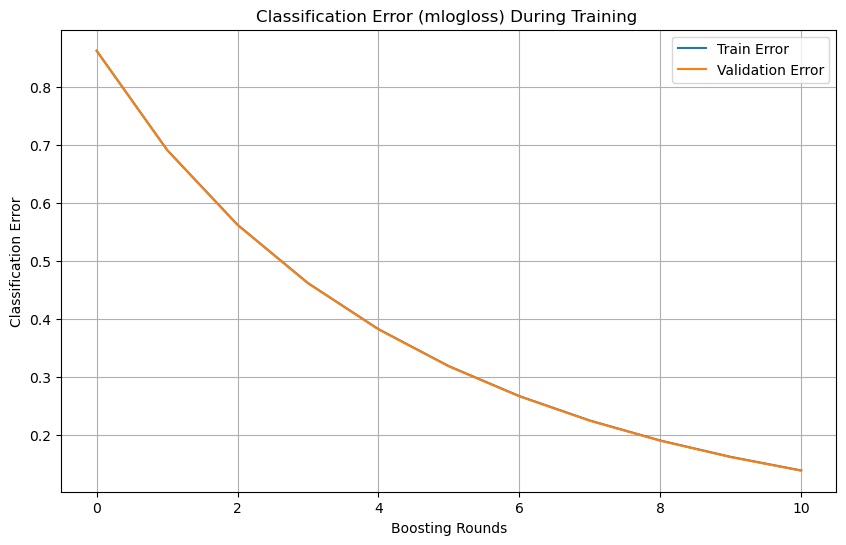

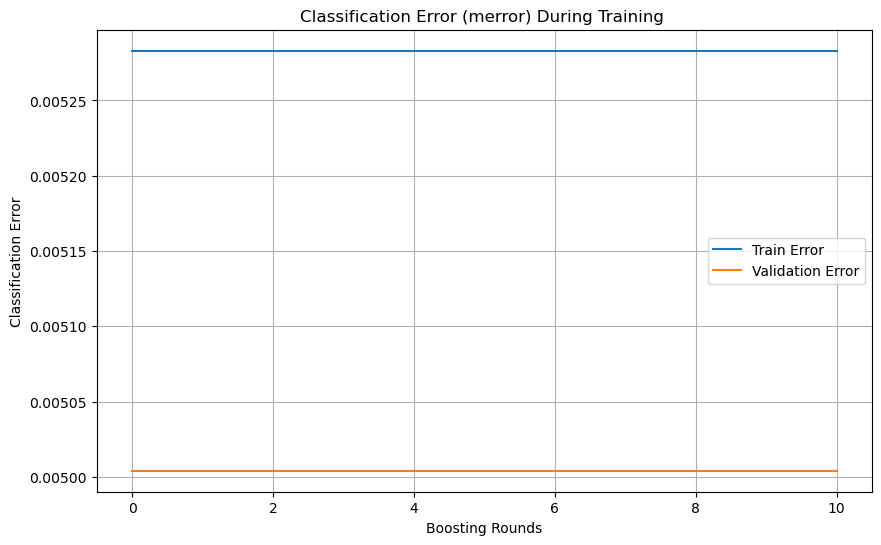

Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes
ROC-AUC Score: 0.9747522523746905
ROC-AUC per class [0, 1, 2]: [0.96558498 0.97992651 0.97874526]


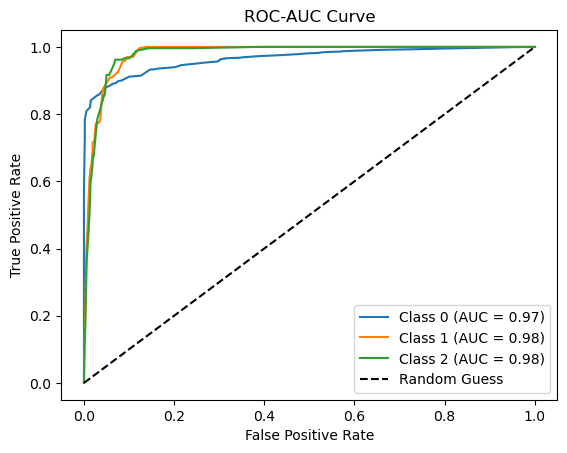

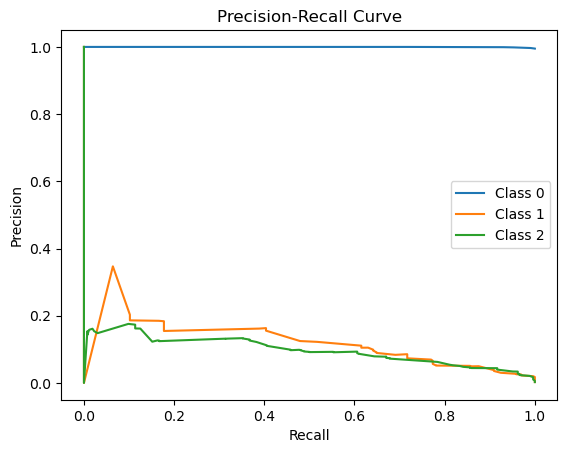

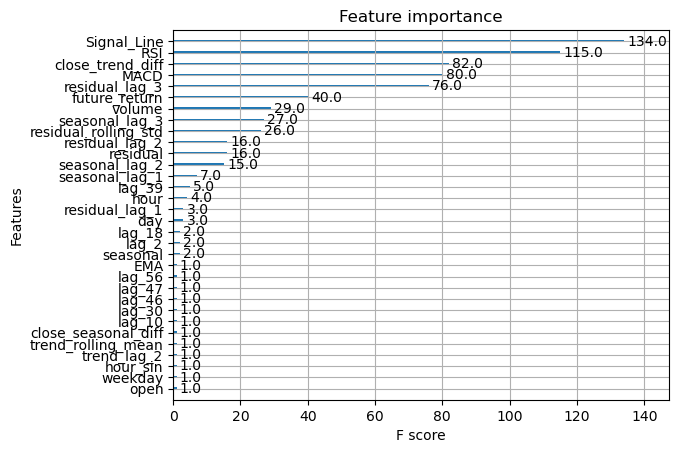

In [87]:
with mlflow.start_run(run_name = mlflow_run_name):
    mlflow.log_param("train size", len(attributes_train))
    mlflow.log_param("test size", len(attributes_test))

    # Create a Optuna study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(
        partial(objective, oversampling_type = oversampling_type, n_splits = 5),
        n_trials = n_trials # adjust the number of trials as needed
    )

    # Visualize optimization history
    optimization_history_plot = vis.plot_optimization_history(study)
    # Visualize parameter importance
    param_importance_plot = vis.plot_param_importances(study)
    # Visualize hyperparameter values
    hyperparameter_values_plot = vis.plot_parallel_coordinate(study)

    # Save visualizations to files
    optimization_history_plot.write_html(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
    param_importance_plot.write_html(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
    hyperparameter_values_plot.write_html(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")

    # Log visualization MLflow artifacts
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_F1_macro-score", study.best_value)

    # Output the best hyperparameters
    print("Best Parameters:", study.best_params)
    print("Best F1-macro-score:", study.best_value)
    print("Best Trial:", study.best_trial)

    # Train the model with evaluation metrics
    eval_set = [(attributes_train, target_train), (attributes_test, target_test)]

    # Train best model
    merged_params = initial_xgboost_model_parameters | study.best_params

    print("merged_params:", merged_params)
    
    model_xgb = XGBClassifier(**merged_params)
    model_xgb.fit(attributes_train, target_train, eval_set = eval_set)

    # Validate
    target_train_pred = model_xgb.predict(attributes_train)
    classification_train_report = classification_report(target_train, target_train_pred)

    target_test_pred = model_xgb.predict(attributes_test)
    classification_test_report = classification_report(target_test, target_test_pred)

    print(f"classification_train_report_{model_type}_{oversampling_type}: ", classification_train_report)
    print(f"classification_test_report_{model_type}_{oversampling_type}: ", classification_test_report)

    # Log metrics
    mlflow.log_metric(f"train_accuracy_{model_type}_{oversampling_type}", model_xgb.score(attributes_train, target_train))
    mlflow.log_metric(f"test_accuracy_{model_type}_{oversampling_type}", model_xgb.score(attributes_test, target_test))

    with open(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt",  "w") as f:
        f.write(classification_train_report)
    with open(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt",  "w") as f:
        f.write(classification_test_report)
        
    pickle.dump(model_xgb, open(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl", "wb"))

    # Log artifacts
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt")
    
    classes = [0, 1, 2]
    evaluate_model(model_xgb, attributes_test, target_test, classes)

### 4.2. GridSearchCV

In [36]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300],
    # 'n_estimators': [100, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 10, 50]
}

# Use TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits = n_splits)

grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid,
    scoring='f1_weighted',  # Use an appropriate scoring metric
    cv=tscv,                # Use TimeSeriesSplit
    verbose=4,
    n_jobs=9
)

# grid_search.fit(attributes_train_smote, target_train_smote)
# print("Best Parameters:", grid_search.best_params_)

# Output best parameters and score
# print("Best parameters:", grid_search.best_params_)
# print("Best accuracy:", grid_search.best_score_)

# Evaluate on test set
# best_model = grid_search.best_estimator_
# test_score = best_model.score(attributes_test, target_test)
# print("Test set accuracy:", test_score)

## 4. Evaluate the Model

**ROC-AUC score:**
   - Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes (1 and 2):

**Precision-Recall Curves:**
   - Precision-recall curves are often more informative for imbalanced datasets. They focus on the trade-off between precision and recall for each class.

In [63]:
def print_classification_report_multiclass(model, attributes_test_data, target_test_data): 
    # Predictions
    target_pred_data = model.predict(attributes_test_data)

    # Calculate F1-score (weighted)
    f1 = f1_score(target_test_data, target_pred_data, average='weighted')

    print(f"F1 score (weighted) : [{f1}]")
    
    # Classification Report
    print("Classification report: ")
    print(classification_report(target_test_data, target_pred_data))

In [64]:
def plot_classification_error(model, eval_metric='mlogloss'):
    # Retrieve evaluation results
    eval_results = model.evals_result()
    
    # Plot classification error
    plt.figure(figsize=(10, 6))
    plt.plot(eval_results['validation_0'][eval_metric], label='Train Error')
    plt.plot(eval_results['validation_1'][eval_metric], label='Validation Error')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Classification Error')
    plt.title(f"Classification Error ({eval_metric}) During Training ")
    plt.legend()
    plt.grid(True)
    plt.show()

In [65]:
def plot_roc_curve_multiclass(model,target_test_data, classes):
    print(f"Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes")
    
    # Binarize labels for one-vs-rest (multiclass ROC-AUC)
    target_test_binarized = label_binarize(target_test_data, classes = classes)
    target_pred_prob = model.predict_proba(attributes_test) # predicted probabilities

    # ROC-AUC for multiclass
    roc_auc = roc_auc_score(target_test, target_pred_prob, multi_class='ovr') # 'ovr' (one-vs-rest), 'ovo'-(one-vs-one)
    print(f"ROC-AUC Score: {roc_auc}")
    
    # Compute ROC-AUC for each class
    roc_auc_per_class = roc_auc_score(target_test_binarized, target_pred_prob, average=None)
    print(f"ROC-AUC per class {classes}:", roc_auc_per_class)

    # Compute ROC curve and ROC-AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(target_test_binarized[:, i], target_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Plot the diagonal
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    
    # Configure the plot
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [66]:
def plot_precision_recal_curve_multiclass(model,target_test_data, classes):
    # Binarize labels for one-vs-rest (multiclass precision-recall)
    target_test_binarized = label_binarize(target_test_data, classes = classes)
    target_pred_prob = model.predict_proba(attributes_test) # predicted probabilities
    
    # Plot precision-recall curves for each class
    for i in range(3):  # Assuming 3 classes (0, 1, 2)
        precision, recall, _ = precision_recall_curve(target_test_binarized[:, i], target_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [67]:
def plot_feature_importance_xgb(model):
    plot_importance(model)

In [68]:
def evaluate_model(model, attributes_test_data, target_test_data, classes):
    print_classification_report_multiclass(model, attributes_test_data, target_test_data)
    plot_classification_error(model, eval_metric='mlogloss')
    plot_classification_error(model, eval_metric='merror')
    plot_roc_curve_multiclass(model, target_test_data, classes)
    plot_precision_recal_curve_multiclass(model, target_test_data, classes)
    plot_feature_importance_xgb(model)

F1 score (weighted) : [0.9934051011788023]
Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105186
           1       0.59      0.11      0.18       265
           2       0.45      0.11      0.17       264

    accuracy                           1.00    105715
   macro avg       0.68      0.40      0.45    105715
weighted avg       0.99      1.00      0.99    105715



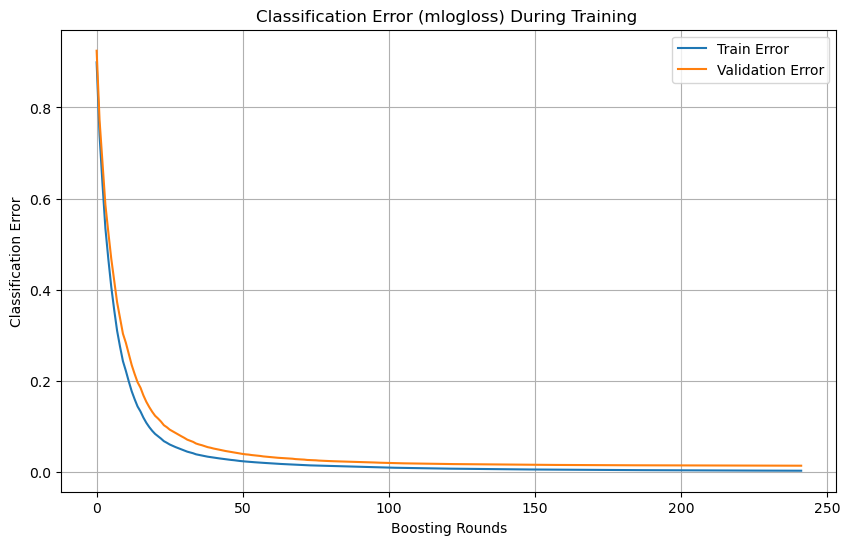

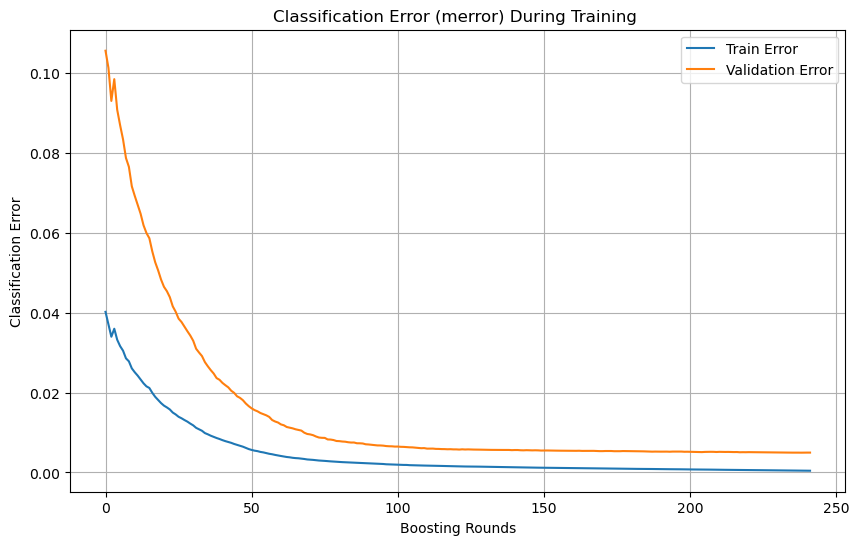

Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes
ROC-AUC Score: 0.9942291268915734
ROC-AUC per class [0, 1, 2]: [0.99133443 0.99598447 0.99536849]


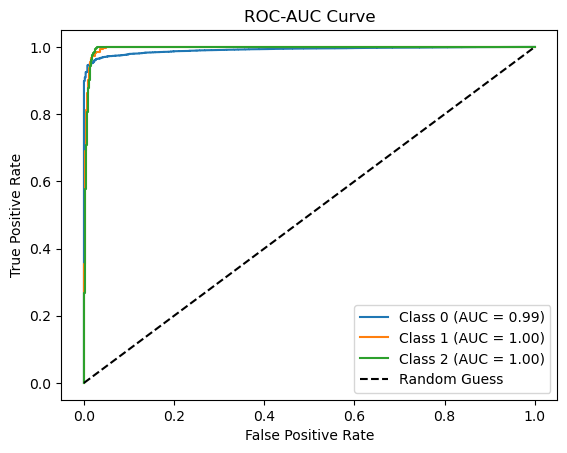

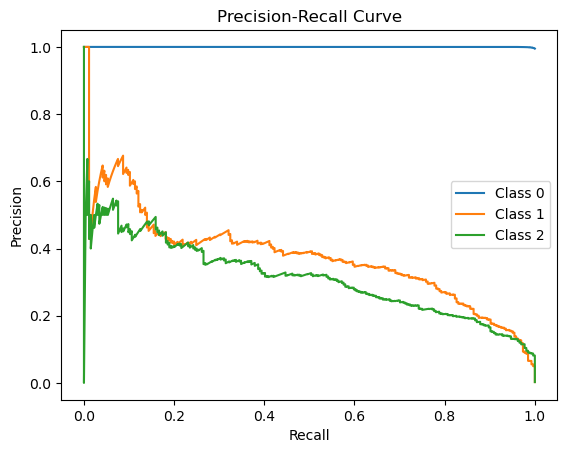

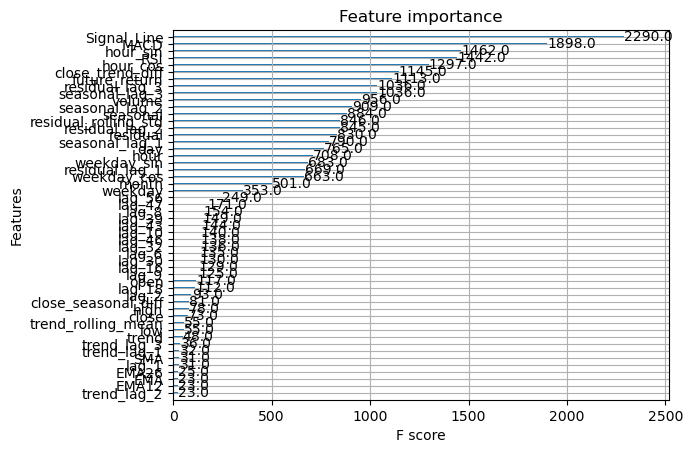

In [90]:
classes = [0, 1, 2]
evaluate_model(model_xgb, attributes_test, target_test, classes)

## 5. Time Series Cross-Validation

In [74]:
def run_time_series_cross_validation(model, attributes_data, oversampling_type = None, n_splits = 5):
    """
    Runs a cross validation for time series data. The 'attributes_data' is splitted with a 'TimeSeriesSplit' in 'n_splits'-folds
    
    Parameters:
    ----------
    model : the xgb model that will be used for the cross validation
    
    attributes_data: attributes data for the cross validation
    
    n_splits : number of splis the data for the cross validation
    
    oversampling_type : applies oversampling to generate synthetic examples for minority classes. Possible values: 'adasyn' or 'smote'
    """ 
    
    print(f"Start time series cross validation with oversampling:[{oversampling_type}] and n_splits:[{n_splits}]")
    
    # Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits = n_splits)
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(attributes_data)):
        attributes_train_fold, attributes_val_fold = attributes.iloc[train_idx], attributes.iloc[val_idx]
        target_train_fold, target_val_fold = target.iloc[train_idx], target.iloc[val_idx]
        
        attributes_train_fold, target_train_fold = create_oversampling(
            attributes_train_fold,
            target_train_fold, 
            oversampling_type = oversampling_type
        )
        
        # Train model 
        model.fit(attributes_train_fold,
                  target_train_fold,  
                  eval_set=[(attributes_val_fold, target_val_fold)],
                  verbose=False)
    
        # Validate
        target_val_pred = model.predict(attributes_val_fold)
        
        print(f"Fold {fold+1} Classification Report")
        print(classification_report(target_val_fold, target_val_pred))

In [75]:
run_time_series_cross_validation(model_xgb, attributes, oversampling_type, n_splits = 5)

Start time series cross validation with oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]
[18:09:14] ======== Monitor (0): HostSketchContainer ========
[18:09:14] AllReduce: 0.013707s, 1 calls @ 13707us

[18:09:14] MakeCuts: 0.013939s, 1 calls @ 13939us

[18:09:15] DEBUG: D:\bld\xgboost-split_1732150467793\work\src\gbm\gbtree.cc:130: Using tree method: 0
[18:09:35] ======== Monitor (0): Learner ========
[18:09:35] Configure: 0.000537s, 1 calls @ 537us

[18:09:35] EvalOneIter: 4.51305s, 257 calls @ 4513055us

[18:09:35] GetGradient: 1.28421s, 257 calls @ 1284205us

[18:09:35] PredictRaw: 0.001196s, 257 calls @ 1196us

[18:09:35] UpdateOneIter: 15.7616s, 257 calls @ 15761551us

[18:09:35] ======== Monitor (0): GBTree ========
[18:09:35] BoostNewTrees: 14.4736s, 257 calls @ 14473597us

[18:09:35] CommitModel: 0.000345s, 257 calls @ 345us

[18:09:35] ======== Monitor (0): HistUpdater =====